In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import json
from nltk.corpus import stopwords
import string as s

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
FILE_PATH = 'resources/clickbait_data.csv'
data = pd.read_csv(FILE_PATH)
data

,headline,clickbait
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1
3,"This Vine Of New York On ""Celebrity Big Brothe...",1
4,A Couple Did A Stunning Photo Shoot With Their...,1
...,...,...
31995,"To Make Female Hearts Flutter in Iraq, Throw a...",0
31996,"British Liberal Democrat Patsy Calton, 56, die...",0
31997,Drone smartphone app to help heart attack vict...,0
31998,"Netanyahu Urges Pope Benedict, in Israel, to D...",0


In [34]:
text = data['headline'].values
labels = data['clickbait'].values

stpwrds = set(stopwords.words('english'))
new_text =[]

_digits_ = str.maketrans('', '', s.digits)

for head in text:
    head = head.translate(_digits_)
    head = head.lower()
    head = ' '.join(list(set(re.split("\W+",head)) - stpwrds))
    new_text.append(head)
    
text_train, text_test, y_train, y_test = train_test_split(new_text, labels)

tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(new_text)

X_train = tokenizer.texts_to_sequences(text_train)
x_test = tokenizer.texts_to_sequences(text_test)

X_train = pad_sequences(X_train, maxlen=100)
x_test = pad_sequences(x_test, maxlen=100)

In [35]:
text_train[0:20]

['sir sugar keep television alan role apprentice',
 ' life changing things october try',
 'assault senator expelled rejects us new appeals convicted court york bid',
 ' grilling day hacks labor',
 'hedgehog annoying moment sonic games',
 'influence latin expands deal china america',
 'lifetime called would movie',
 'grandma jagger swift best mick reaction bringing taylor onstage',
 ' make feel friends legitimately old facts',
 ' beijing set protest apparent car fire',
 'highlights u skating weir lysacek championships versus figure',
 'turmoil boost u midst gets research group ukraine',
 ' characters vegas fallout new',
 'menu us sliced tomatoes mcdonald pull',
 'oversaving times burden',
 'u trucking diet putting',
 ' obsessed shameless things band become happen',
 ' awesome life totally make fun products',
 'hughes big inning track winning puts one',
 'launches attacks afghanistan taliban capital series']

In [52]:
n = []

for h in text:
    n.extend(h.split(' '))
    
vocab = len(pd.Series(n).unique())

In [53]:
model = Sequential()
model.add(Embedding(vocab+1, 32, input_length=100))
model.add(LSTM(32, return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 32)           1145312   
_________________________________________________________________
lstm (LSTM)                  (None, 100, 32)           8320      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,153,665
Trainable params: 1,153,665
Non-trainable params: 0
_________________________________________________________________


In [54]:
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        min_delta=1e-4,
        patience=3,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='weights.h5',
        monitor='val_accuracy', 
        mode='max', 
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]


In [55]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, 
                    y_train, 
                    batch_size=512, 
                    validation_data=(x_test, y_test), 
                    epochs=20, 
                    callbacks=callbacks)






Epoch 1/20
47/47 [==============================] - ETA: 0s - loss: 0.6714 - accuracy: 0.7801
Epoch 00001: val_accuracy improved from -inf to 0.77975, saving model to weights.h5
47/47 [==============================] - 39s 821ms/step - loss: 0.6714 - accuracy: 0.7801 - val_loss: 0.6106 - val_accuracy: 0.7797
Epoch 2/20
47/47 [==============================] - ETA: 0s - loss: 0.5340 - accuracy: 0.8435
Epoch 00002: val_accuracy improved from 0.77975 to 0.87800, saving model to weights.h5
47/47 [==============================] - 34s 730ms/step - loss: 0.5340 - accuracy: 0.8435 - val_loss: 0.4510 - val_accuracy: 0.8780
Epoch 3/20
47/47 [==============================] - ETA: 0s - loss: 0.3649 - accuracy: 0.9398
Epoch 00003: val_accuracy improved from 0.87800 to 0.94750, saving model to weights.h5
47/47 [==============================] - 35s 752ms/step - loss: 0.3649 - accuracy: 0.9398 - val_loss: 0.3031 - val_accuracy: 0.9475
Epoch 4/20
47/47 [==============================] - ETA: 0s - lo

In [56]:
model.load_weights('weights.h5')
model.save('model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model/assets


<Figure size 432x288 with 0 Axes>

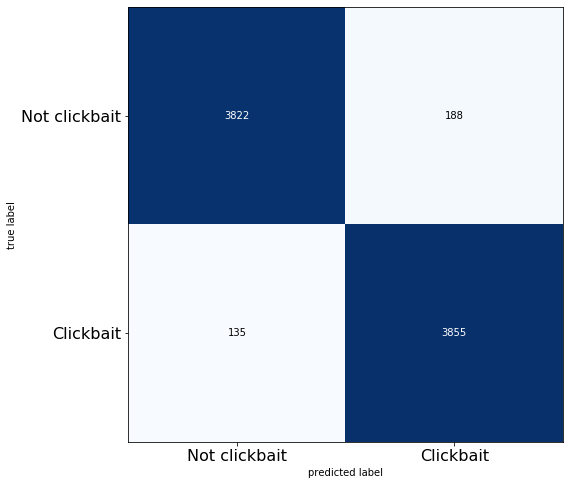

In [61]:
preds = [round(i[0]) for i in model.predict(x_test)]
cm = confusion_matrix(y_test, preds)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Not clickbait', 'Clickbait'], fontsize=16)
plt.yticks(range(2), ['Not clickbait', 'Clickbait'], fontsize=16)
plt.show()

In [62]:
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.97
Precision of the model is 0.95


In [69]:

def predict(test):
    
    for t in test:
        t = t.translate(_digits_)
        t = t.lower()
        t = ' '.join(list(set(re.split("\W+",t)) - stpwrds))

    token_text = pad_sequences(tokenizer.texts_to_sequences(test), maxlen=100)

    preds = [round(i[0]) for i in model.predict(token_text)]
    for (text, pred) in zip(test, preds):
        label = 'Clickbait' if pred == 1.0 else 'Not Clickbait'
        print("{} - {}".format(text, label))
